In [1]:
from fairness.matching import compute
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('./dataset/adult.data', sep=',')

In [3]:
dataset

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [4]:
dataset.iloc[:, len(dataset.columns) - 1:]

,<=50K
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K
...,...
32555,<=50K
32556,>50K
32557,<=50K
32558,<=50K


In [5]:
columns_to_drop = ['39']
protected_attributes = [' White', ' Never-married', ' Male']
output_column = ' <=50K'

In [6]:
fair_dataset = compute(dataset, protected_attributes, output_column, columns_to_drop)

In [7]:
fair_dataset

,State-gov,77516,Bachelors,13,2174,0,40,<=50K
0,6,83311,9,13,0,0,13,0
1,4,215646,11,9,0,0,40,0
2,4,234721,1,7,0,0,40,0
3,4,338409,9,13,0,0,40,0
4,4,284582,12,14,0,0,40,0
...,...,...,...,...,...,...,...,...
32555,4,257302,7,12,0,0,38,0
32556,4,154374,11,9,0,0,40,1
32557,4,151910,11,9,0,0,40,0
32558,4,201490,11,9,0,0,20,0


In [8]:
fair_dataset.rename(columns={" <=50K": "50K"}, inplace=True)

In [9]:
output_column = "50K"

In [10]:
fair_dataset

,State-gov,77516,Bachelors,13,2174,0,40,50K
0,6,83311,9,13,0,0,13,0
1,4,215646,11,9,0,0,40,0
2,4,234721,1,7,0,0,40,0
3,4,338409,9,13,0,0,40,0
4,4,284582,12,14,0,0,40,0
...,...,...,...,...,...,...,...,...
32555,4,257302,7,12,0,0,38,0
32556,4,154374,11,9,0,0,40,1
32557,4,151910,11,9,0,0,40,0
32558,4,201490,11,9,0,0,20,0


In [11]:
X = fair_dataset.iloc[:,:len(fair_dataset.columns) - 2]
y = fair_dataset.loc[:, output_column:]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
standard_scaler_train = StandardScaler()
X_train = standard_scaler_train.fit_transform(X_train)

standard_scaler_test = StandardScaler()
X_test = standard_scaler_test.fit_transform(X_test)

In [14]:
estimator = xgb.XGBClassifier(
    objective='binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [15]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring='roc_auc',
    n_jobs=10,
    cv=10,
    verbose=True
)

In [16]:
grid_search_classifier = grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


In [17]:
y_pred = grid_search_classifier.predict(X_test)

In [18]:
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4768  144]
 [1109  491]]
0.807585995085995
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      4912
           1       0.77      0.31      0.44      1600

    accuracy                           0.81      6512
   macro avg       0.79      0.64      0.66      6512
weighted avg       0.80      0.81      0.77      6512



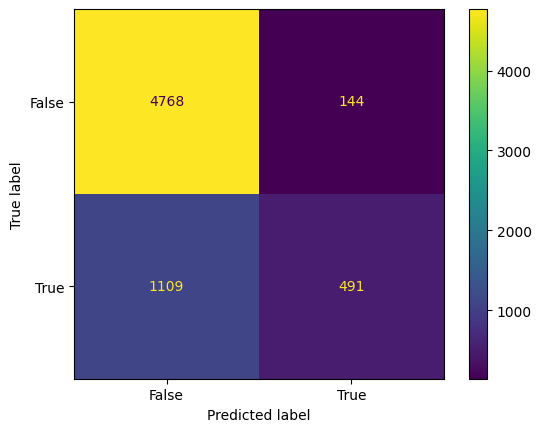

In [19]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=[False, True])
cm_display.plot()
plt.show()